<a href="https://colab.research.google.com/github/sleepy5300/TensorFlow-in-Practice-Specialization/blob/master/Copy_of_Course_4_Week_3_Exercise_Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tf-nightly-2.0-preview


     |████████████████████████████████| 95.2MB 1.3MB/s 
     |████████████████████████████████| 3.8MB 37.3MB/s 
     |████████████████████████████████| 450kB 39.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=a00edf7d6bc655a5ab7d0decd37ae410c78a2dddbed401edaf27b45580693ed6
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.2
    Uninstalling gast-0.3.2:
      Successfully uninstalled gast-0.3.2


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-dev20191002


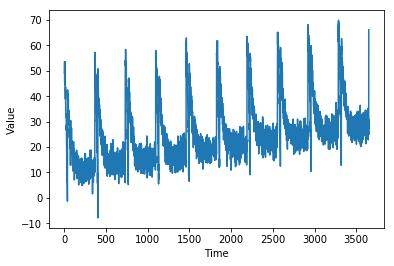

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
  # YOUR CODE HERE
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(window_size, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(window_size)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 8s 81ms/step - loss: 10.7472 - mae: 11.1503
Epoch 2/100
94/94 [==============================] - 3s 28ms/step - loss: 10.4604 - mae: 10.9115
Epoch 3/100
94/94 [==============================] - 3s 29ms/step - loss: 10.2298 - mae: 10.6963
Epoch 4/100
94/94 [==============================] - 3s 28ms/step - loss: 10.0488 - mae: 10.5158
Epoch 5/100
94/94 [==============================] - 3s 29ms/step - loss: 9.8558 - mae: 10.3476
Epoch 6/100
94/94 [==============================] - 3s 29ms/step - loss: 9.6638 - mae: 10.1956
Epoch 7/100
94/94 [==============================] - 3s 29ms/step - loss: 9.5371 - mae: 10.0598
Epoch 8/100
94/94 [==============================] - 3s 29ms/step - loss: 9.3956 - mae: 9.9233
Epoch 9/100
94/94 [==============================] - 3s 29ms/step - loss: 9.2796 - mae: 9.7926
Epoch 10/100
94/94 [==============================] - 3s 29ms/step - loss: 9.1185 - mae: 9.6546
Epoch 11/100
94/94 [==================

[1e-08, 0.0001, 0, 30]

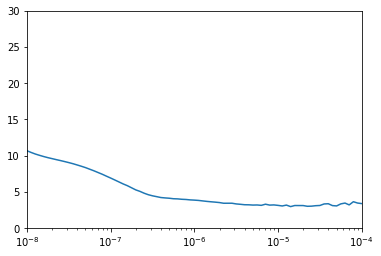

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

# FROM THIS PICK A LEARNING RATE

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
  # YOUR CODE HERE
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(window_size, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(window_size)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)
                                                            
# FIND A MODEL AND A LR THAT TRAINS TO AN MAE < 3                                                          

Epoch 1/500
94/94 [==============================] - 7s 78ms/step - loss: 5.1640 - mae: 5.5747
Epoch 2/500
94/94 [==============================] - 3s 29ms/step - loss: 3.9084 - mae: 4.3780
Epoch 3/500
94/94 [==============================] - 3s 29ms/step - loss: 3.7004 - mae: 4.1867
Epoch 4/500
94/94 [==============================] - 3s 29ms/step - loss: 3.4882 - mae: 3.9630
Epoch 5/500
94/94 [==============================] - 3s 29ms/step - loss: 3.3945 - mae: 3.8695
Epoch 6/500
94/94 [==============================] - 3s 29ms/step - loss: 3.2314 - mae: 3.7087
Epoch 7/500
94/94 [==============================] - 3s 30ms/step - loss: 3.3237 - mae: 3.8066
Epoch 8/500
94/94 [==============================] - 3s 30ms/step - loss: 3.1966 - mae: 3.6770
Epoch 9/500
94/94 [==============================] - 3s 29ms/step - loss: 3.2980 - mae: 3.7637
Epoch 10/500
94/94 [==============================] - 3s 29ms/step - loss: 3.2780 - mae: 3.7423
Epoch 11/500
94/94 [=============================

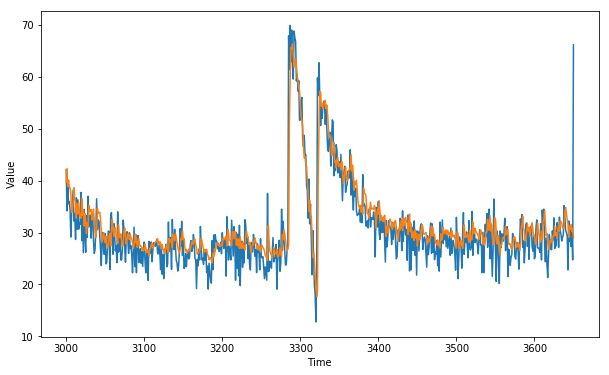

In [0]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

# YOUR RESULT HERE SHOULD BE LESS THAN 4

3.2232563

<Figure size 432x288 with 0 Axes>

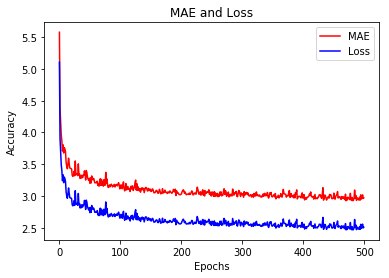

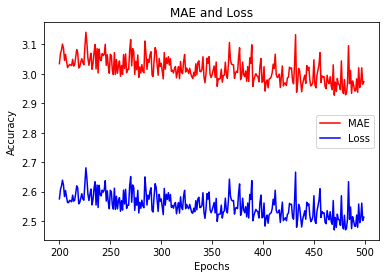

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()